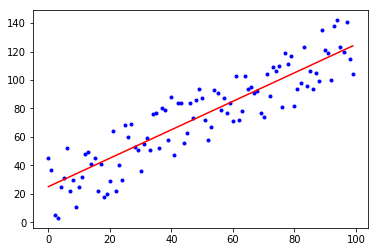

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn.covariance as cor

os.chdir('d:\\testcode')
data = pd.read_csv('train.csv')

c = np.zeros(100)

for i in range(100):
    c[i]=i+np.random.randint(50)


plt.plot(c,'.b',range(100)+25*np.ones(100),'r')
plt.show()



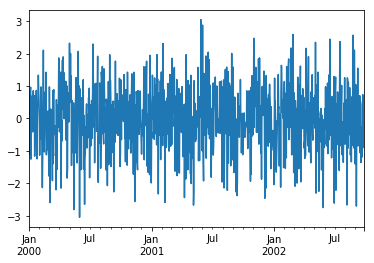

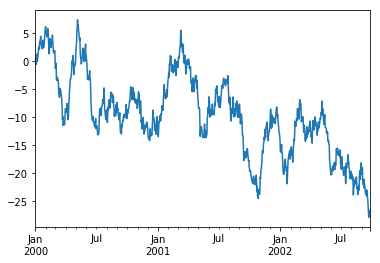

In [2]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
plt.figure();ts.plot();plt.show()
ts1 = ts.cumsum()
plt.figure();ts1.plot();plt.show()

In [24]:
np.shape(data[data['Cabin'].notnull()])
#data[data['Cabin'].notnull()].groupby('Cabin').first()
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


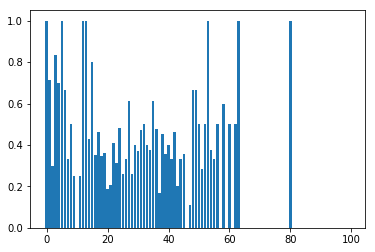

In [3]:
a = data[data['Age'].notnull()][['Survived','Age']]
a['Age'] = a['Age'].astype('int')

l=100
count = np.zeros(l)
for i in range(l):
    agetotal = a[a['Age']==i]['Survived'].count()
    if agetotal>0:
        count[i] = sum(a[a['Age']==i]['Survived'])/agetotal

plt.bar(range(l),count)
plt.show()


In [29]:
#data['Pclass'].corr(data['Survived'])
print("mean survived of Embarked in C:"+str(data[data['Embarked'].isin(['C'])]['Survived'].mean()))
print("mean survived of Embarked in S:"+str(data[data['Embarked'].isin(['S'])]['Survived'].mean()))
print("mean survived of Embarked in Q:"+str(data[data['Embarked'].isin(['Q'])]['Survived'].mean()))
print("mean survived of Sex in female:"+str(data[data['Sex'].isin(['female'])]['Survived'].mean()))
print("mean survived of Sex in male:"+str(data[data['Sex'].isin(['male'])]['Survived'].mean()))

mean survived of Embarked in C:0.5535714285714286
mean survived of Embarked in S:0.33695652173913043
mean survived of Embarked in Q:0.38961038961038963
mean survived of Sex in female:0.7420382165605095
mean survived of Sex in male:0.18890814558058924
